In [45]:
import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import pandas as pd
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
import json
import os

In [2]:
def ConvBlock(filters, model, layers):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [3]:
def FullyConnectedLayer(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [4]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
def preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]

In [5]:
def ft(model, num):
    model.pop()
    for layer in model.layers: layer.trainable=False
    model.add(Dense(num, activation='softmax'))
    model = compile(model)
    return model

def finetune(model, batches):
    model = ft(model, batches.nb_class)
    classes = list(iter(batches.class_indices)) # get a list of all the class labels
    for c in batches.class_indices:
        classes[batches.class_indices[c]] = c
    return model, classes


def compile(model, lr=0.001):
    model.compile(optimizer=Adam(lr=lr),
            loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def fit(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
            validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
    return model

In [6]:
def VGGModel():
    model= Sequential()
    model.add(Lambda(preprocess, input_shape=(3,224,224)))
    ConvBlock(64, model, 2)
    ConvBlock(128, model, 2)
    ConvBlock(256, model, 3)
    ConvBlock(512, model, 3)
    ConvBlock(512, model, 3)
    
    model.add(Flatten())
    FullyConnectedLayer(model)
    FullyConnectedLayer(model)
    model.add(Dense(1000, activation='softmax'))
    return model
    

In [8]:
path = '../data/catsanddogs/'

In [9]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE)
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [10]:
model = VGGModel()

/Users/sanjeev/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/Users/sanjeev/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/Users/sanjeev/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [11]:
model_weight = get_file('vgg16.h5', FILES_PATH+'vgg16.h5')
model.load_weights(model_weight)

In [12]:
batch_size = 4
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [13]:
import utils; reload(utils)
from utils import plots

In [14]:
train_batches = get_batches('train', batch_size=4)
print train_batches.filenames
val_batches = get_batches('valid', batch_size=4)

Found 12 images belonging to 2 classes.
['cats/cat.0.jpg', 'cats/cat.1.jpg', 'cats/cat.2.jpg', 'cats/cat.3.jpg', 'cats/cat.4.jpg', 'cats/cat.5.jpg', 'dogs/dog.0.jpg', 'dogs/dog.1.jpg', 'dogs/dog.2.jpg', 'dogs/dog.3.jpg', 'dogs/dog.4.jpg', 'dogs/dog.5.jpg']
Found 4 images belonging to 2 classes.


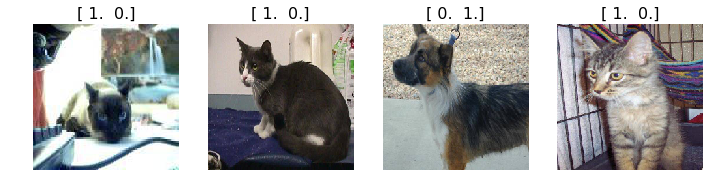

In [15]:
images, labels = next(train_batches)
plots(images, titles=labels)

In [16]:
model, classes = finetune(model, train_batches)
type(model)

keras.models.Sequential

In [17]:
model = fit(model, train_batches, val_batches, nb_epoch=1)

Epoch 1/1
12/12 [==============================] - 5s - loss: 1.4029 - acc: 0.5833 - val_loss: 1.2618 - val_acc: 0.2500


In [18]:
type(model)

keras.models.Sequential

In [29]:
test_batches = get_batches('test', batch_size= 4, class_mode=None, shuffle=False)
test_images = next(test_batches)
test_batches.nb_sample

Found 6 images belonging to 1 classes.


6

In [7]:
def pred_batch(model, imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes))
    print('First 5 probabilities: {}\n'.format(preds))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [50]:
def pred_generator(model, test_batches):
    preds = model.predict_generator(test_batches, test_batches.nb_sample)
    idxs = np.argmax(preds, axis=1)
    prob = preds[:,1]
    print preds
    print idxs
    print prob
    return prob

In [51]:
filenames = list(test_batches.filenames)
a = [os.path.basename(i).replace('.jpg', '') for i in filenames]
a

['cat.12443', 'cat.12444', 'cat.12445', 'dog.66', 'dog.67', 'dog.68']

In [52]:
# prediction = model.predict_generator(test_batches, test_batches.nb_sample)
prob = pred_generator(model, test_batches)

[[ 0.5736  0.4264]
 [ 0.4233  0.5767]
 [ 0.5317  0.4683]
 [ 0.3325  0.6675]
 [ 0.5867  0.4133]
 [ 0.3973  0.6027]]
[0 1 0 1 0 1]
[ 0.4264  0.5767  0.4683  0.6675  0.4133  0.6027]


In [55]:
submission_df = pd.DataFrame([a,list(prob)], columns=['id', 'label'])
submission_df

AssertionError: 2 columns passed, passed data had 6 columns

In [26]:
pred_batch(model, test_images)

Shape: (4, 2)
First 5 classes: ['cats', 'dogs']
First 5 probabilities: [[ 0.5317  0.4683]
 [ 0.3325  0.6675]
 [ 0.5867  0.4133]
 [ 0.3973  0.6027]]

Predictions prob/class: 
  0.5317/cats
  0.6675/dogs
  0.5867/cats
  0.6027/dogs
